In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime

W1104 10:44:58.912312 43808 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1104 10:44:58.937308 43808 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob, chalie, dave]
frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
def generateLoadersPerClass(dataset):
    #loaders per class
    loaders_per_class = []
    for class_name in dataset.classes:
        # get the indices in the dataset that are relative to that class
        idx = [
            pos for pos, item in enumerate(dataset.samples)
            if item[1] == dataset.class_to_idx[class_name]]
        # construct the corresponding dataloader thanks to a SubsetRandomSampler
        loaders_per_class += [torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=SubsetRandomSampler(idx),
            **kwargs)]
    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign data
yalefaces = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original',
                             transform=data_transform)
original_loaders = generateLoadersPerClass(yalefaces)

#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original_test',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)

# Load backdoor dataset

In [6]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_tattoo',
                             transform=data_transform)
#malicious data
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loaders = generateLoadersPerClass(backdoored)


#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_tattoo_test',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]
dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

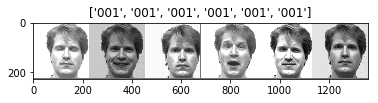

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = yalefaces.classes
# Get a batch of training data
inputs, classes = next(iter(original_loaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Send dataset to clients

In [ ]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#EACH CLIENT KNOWS EACH CLASS
#normal clients
for loader in original_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                train_distributed_dataset.append((data_append, target_append))

#backdoored clients
for loader in backdoored_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
                target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
                train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [ ]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
                100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [ ]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
           for data, target in test_loader:
               data, target = data.to(device), target.to(device)
               output = model(data)
               test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
               pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
               correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [ ]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented70.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_faces_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
csv_header += "#way backdoor looks like: " + "tattoo" + "\n"
csv_header += "#order of time: " + "backdoors first" + "\n"
csv_header += "#attack model: " + "basic" + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 500):
    csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train backdoor
    avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_backdoor = datetime.datetime.now().strftime("%H%M%S")
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"
    timestamp_normal = datetime.datetime.now().strftime("%H%M%S")

    #save after each 10 iterations
    if epoch % 10 == 0:
        torch.save(model.state_dict(), ("exp_faces_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    test_loss, acc = test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"

    #scheduler.step(test_loss)
    
    #timestamp
    csv_normal += timestamp_normal + "\n"
    csv_backdoor += timestamp_backdoor + "\n"
    
    #Write to file
    f= open(("exp_faces_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()

    



#merge strategy: sequential
#number of distributed sources: 5
#batch size: 10
#distribution of data: equally distributed subset
#percentage of backdoored nodes: 0.2
#percentage of poisoned data in backdoored nodes: 100
#way backdoor looks like: tattoo
#order of time: backdoors first
#attack model: basic
#starttime: 104602
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Train Epoch: 1 [0/30 (0%)]	Loss: 2.572305
Train Epoch: 1 [10/30 (33%)]	Loss: 2.553903
Train Epoch: 1 [20/30 (67%)]	Loss: 2.533670
Average training loss: 2.553292751312256
Train Epoch: 1 [0/130 (0%)]	Loss: 2.561406
Train Epoch: 1 [10/130 (8%)]	Loss: 2.571562
Train Epoch: 1 [20/130 (15%)]	Loss: 2.580849
Train Epoch: 1 [30/130 (23%)]	Loss: 2.569628
Train Epoch: 1 [40/130 (31%)]	Loss: 2.593039
Train Epoch: 1 [50/130 (38%)]	Loss: 2.583146
Train Epoch: 1 [60/130 (46%)]	Loss: 2.581492
Train Epoch: 1 [70/130 (54%)]	Loss: 2.585477
Train Epoch: 1 [80/130 (62%)]	Loss: 2.576133
Train Ep

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 4 [0/30 (0%)]	Loss: 2.405536
Train Epoch: 4 [10/30 (33%)]	Loss: 2.379529
Train Epoch: 4 [20/30 (67%)]	Loss: 2.342415
Average training loss: 2.375826835632324
Train Epoch: 4 [0/130 (0%)]	Loss: 2.576242
Train Epoch: 4 [10/130 (8%)]	Loss: 2.586841
Train Epoch: 4 [20/130 (15%)]	Loss: 2.595313
Train Epoch: 4 [30/130 (23%)]	Loss: 2.589414
Train Epoch: 4 [40/130 (31%)]	Loss: 2.611725
Train Epoch: 4 [50/130 (38%)]	Loss: 2.605751
Train Epoch: 4 [60/130 (46%)]	Loss: 2.603562
Train Epoch: 4 [70/130 (54%)]	Loss: 2.603658
Train Epoch: 4 [80/130 (62%)]	Loss: 2.596706
Train Epoch: 4 [90/130 (69%)]	Loss: 2.351876
Train Epoch: 4 [100/130 (77%)]	Loss: 2.590568
Train Epoch: 4 [110/130 (85%)]	Loss: 2.612780
Train Epoch: 4 [120/130 (92%)]	Loss: 2.595039
Average training loss: 2.5784213542938232

Test set: Average loss: 2.3311, Accuracy: 13/13 (100%)

tensor([[13.,  0.,  0

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 7 [0/30 (0%)]	Loss: 2.129846
Train Epoch: 7 [10/30 (33%)]	Loss: 2.021830
Train Epoch: 7 [20/30 (67%)]	Loss: 1.736634
Average training loss: 1.9627704620361328
Train Epoch: 7 [0/130 (0%)]	Loss: 2.717693
Train Epoch: 7 [10/130 (8%)]	Loss: 2.725347
Train Epoch: 7 [20/130 (15%)]	Loss: 2.669252
Train Epoch: 7 [30/130 (23%)]	Loss: 2.710345
Train Epoch: 7 [40/130 (31%)]	Loss: 2.714561
Train Epoch: 7 [50/130 (38%)]	Loss: 2.687236
Train Epoch: 7 [60/130 (46%)]	Loss: 2.696695
Train Epoch: 7 [70/130 (54%)]	Loss: 2.683564
Train Epoch: 7 [80/130 (62%)]	Loss: 2.670036
Train Epoch: 7 [90/130 (69%)]	Loss: 2.062385
Train Epoch: 7 [100/130 (77%)]	Loss: 2.684679
Train Epoch: 7 [110/130 (85%)]	Loss: 2.708292
Train Epoch: 7 [120/130 (92%)]	Loss: 2.660095
Average training loss: 2.6453983783721924

Test set: Average loss: 2.0599, Accuracy: 13/13 (100%)

tensor([[13.,  0.,  

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 10 [0/30 (0%)]	Loss: 2.055474
Train Epoch: 10 [10/30 (33%)]	Loss: 1.921082
Train Epoch: 10 [20/30 (67%)]	Loss: 1.607632
Average training loss: 1.861396074295044
Train Epoch: 10 [0/130 (0%)]	Loss: 2.602222
Train Epoch: 10 [10/130 (8%)]	Loss: 2.669114
Train Epoch: 10 [20/130 (15%)]	Loss: 2.681043
Train Epoch: 10 [30/130 (23%)]	Loss: 2.684939
Train Epoch: 10 [40/130 (31%)]	Loss: 2.725778
Train Epoch: 10 [50/130 (38%)]	Loss: 2.749087
Train Epoch: 10 [60/130 (46%)]	Loss: 2.730729
Train Epoch: 10 [70/130 (54%)]	Loss: 2.731907
Train Epoch: 10 [80/130 (62%)]	Loss: 2.711237
Train Epoch: 10 [90/130 (69%)]	Loss: 2.010973
Train Epoch: 10 [100/130 (77%)]	Loss: 2.695030
Train Epoch: 10 [110/130 (85%)]	Loss: 2.719980
Train Epoch: 10 [120/130 (92%)]	Loss: 2.693969
Average training loss: 2.646615982055664

Test set: Average loss: 2.0223, Accuracy: 13/13 (100%)

tensor

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 13 [0/30 (0%)]	Loss: 2.015748
Train Epoch: 13 [10/30 (33%)]	Loss: 1.892773
Train Epoch: 13 [20/30 (67%)]	Loss: 1.612090
Average training loss: 1.8402036428451538
Train Epoch: 13 [0/130 (0%)]	Loss: 2.573820
Train Epoch: 13 [10/130 (8%)]	Loss: 2.606922
Train Epoch: 13 [20/130 (15%)]	Loss: 2.630993
Train Epoch: 13 [30/130 (23%)]	Loss: 2.655878
Train Epoch: 13 [40/130 (31%)]	Loss: 2.715197
Train Epoch: 13 [50/130 (38%)]	Loss: 2.754273
Train Epoch: 13 [60/130 (46%)]	Loss: 2.750932
Train Epoch: 13 [70/130 (54%)]	Loss: 2.755402
Train Epoch: 13 [80/130 (62%)]	Loss: 2.735963
Train Epoch: 13 [90/130 (69%)]	Loss: 1.941989
Train Epoch: 13 [100/130 (77%)]	Loss: 2.730781
Train Epoch: 13 [110/130 (85%)]	Loss: 2.749715
Train Epoch: 13 [120/130 (92%)]	Loss: 2.722549
Average training loss: 2.6403398513793945

Test set: Average loss: 1.9913, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 16 [0/30 (0%)]	Loss: 1.984335
Train Epoch: 16 [10/30 (33%)]	Loss: 1.878738
Train Epoch: 16 [20/30 (67%)]	Loss: 1.660961
Average training loss: 1.8413445949554443
Train Epoch: 16 [0/130 (0%)]	Loss: 2.579941
Train Epoch: 16 [10/130 (8%)]	Loss: 2.558945
Train Epoch: 16 [20/130 (15%)]	Loss: 2.607754
Train Epoch: 16 [30/130 (23%)]	Loss: 2.613686
Train Epoch: 16 [40/130 (31%)]	Loss: 2.664928
Train Epoch: 16 [50/130 (38%)]	Loss: 2.756125
Train Epoch: 16 [60/130 (46%)]	Loss: 2.773659
Train Epoch: 16 [70/130 (54%)]	Loss: 2.768330
Train Epoch: 16 [80/130 (62%)]	Loss: 2.751496
Train Epoch: 16 [90/130 (69%)]	Loss: 1.901147
Train Epoch: 16 [100/130 (77%)]	Loss: 2.722941
Train Epoch: 16 [110/130 (85%)]	Loss: 2.762697
Train Epoch: 16 [120/130 (92%)]	Loss: 2.741064
Average training loss: 2.6309781074523926

Test set: Average loss: 1.9475, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 19 [0/30 (0%)]	Loss: 1.941428
Train Epoch: 19 [10/30 (33%)]	Loss: 1.851146
Train Epoch: 19 [20/30 (67%)]	Loss: 1.630296
Average training loss: 1.8076236248016357
Train Epoch: 19 [0/130 (0%)]	Loss: 2.591612
Train Epoch: 19 [10/130 (8%)]	Loss: 2.574629
Train Epoch: 19 [20/130 (15%)]	Loss: 2.602780
Train Epoch: 19 [30/130 (23%)]	Loss: 2.596441
Train Epoch: 19 [40/130 (31%)]	Loss: 2.641383
Train Epoch: 19 [50/130 (38%)]	Loss: 2.759062
Train Epoch: 19 [60/130 (46%)]	Loss: 2.749073
Train Epoch: 19 [70/130 (54%)]	Loss: 2.770323
Train Epoch: 19 [80/130 (62%)]	Loss: 2.771332
Train Epoch: 19 [90/130 (69%)]	Loss: 1.838810
Train Epoch: 19 [100/130 (77%)]	Loss: 2.741408
Train Epoch: 19 [110/130 (85%)]	Loss: 2.775465
Train Epoch: 19 [120/130 (92%)]	Loss: 2.753280
Average training loss: 2.6281228065490723

Test set: Average loss: 1.9054, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 22 [0/30 (0%)]	Loss: 1.906029
Train Epoch: 22 [10/30 (33%)]	Loss: 1.811342
Train Epoch: 22 [20/30 (67%)]	Loss: 1.618399
Average training loss: 1.7785900831222534
Train Epoch: 22 [0/130 (0%)]	Loss: 2.607574
Train Epoch: 22 [10/130 (8%)]	Loss: 2.576496
Train Epoch: 22 [20/130 (15%)]	Loss: 2.589197
Train Epoch: 22 [30/130 (23%)]	Loss: 2.601394
Train Epoch: 22 [40/130 (31%)]	Loss: 2.630568
Train Epoch: 22 [50/130 (38%)]	Loss: 2.747086
Train Epoch: 22 [60/130 (46%)]	Loss: 2.762439
Train Epoch: 22 [70/130 (54%)]	Loss: 2.783656
Train Epoch: 22 [80/130 (62%)]	Loss: 2.780918
Train Epoch: 22 [90/130 (69%)]	Loss: 1.795388
Train Epoch: 22 [100/130 (77%)]	Loss: 2.741638
Train Epoch: 22 [110/130 (85%)]	Loss: 2.771816
Train Epoch: 22 [120/130 (92%)]	Loss: 2.756768
Average training loss: 2.6265339851379395

Test set: Average loss: 1.8619, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 25 [0/30 (0%)]	Loss: 1.868033
Train Epoch: 25 [10/30 (33%)]	Loss: 1.772774
Train Epoch: 25 [20/30 (67%)]	Loss: 1.571837
Average training loss: 1.7375478744506836
Train Epoch: 25 [0/130 (0%)]	Loss: 2.636972
Train Epoch: 25 [10/130 (8%)]	Loss: 2.594189
Train Epoch: 25 [20/130 (15%)]	Loss: 2.612801
Train Epoch: 25 [30/130 (23%)]	Loss: 2.605215
Train Epoch: 25 [40/130 (31%)]	Loss: 2.615217
Train Epoch: 25 [50/130 (38%)]	Loss: 2.733915
Train Epoch: 25 [60/130 (46%)]	Loss: 2.753871
Train Epoch: 25 [70/130 (54%)]	Loss: 2.791765
Train Epoch: 25 [80/130 (62%)]	Loss: 2.788436
Train Epoch: 25 [90/130 (69%)]	Loss: 1.740685
Train Epoch: 25 [100/130 (77%)]	Loss: 2.737096
Train Epoch: 25 [110/130 (85%)]	Loss: 2.786418
Train Epoch: 25 [120/130 (92%)]	Loss: 2.773445
Average training loss: 2.6284637451171875

Test set: Average loss: 1.8251, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 28 [0/30 (0%)]	Loss: 1.823494
Train Epoch: 28 [10/30 (33%)]	Loss: 1.748899
Train Epoch: 28 [20/30 (67%)]	Loss: 1.549938
Average training loss: 1.7074437141418457
Train Epoch: 28 [0/130 (0%)]	Loss: 2.636539
Train Epoch: 28 [10/130 (8%)]	Loss: 2.586021
Train Epoch: 28 [20/130 (15%)]	Loss: 2.603946
Train Epoch: 28 [30/130 (23%)]	Loss: 2.602024
Train Epoch: 28 [40/130 (31%)]	Loss: 2.598634
Train Epoch: 28 [50/130 (38%)]	Loss: 2.738760
Train Epoch: 28 [60/130 (46%)]	Loss: 2.760285
Train Epoch: 28 [70/130 (54%)]	Loss: 2.797945
Train Epoch: 28 [80/130 (62%)]	Loss: 2.792585
Train Epoch: 28 [90/130 (69%)]	Loss: 1.701768
Train Epoch: 28 [100/130 (77%)]	Loss: 2.758194
Train Epoch: 28 [110/130 (85%)]	Loss: 2.791645
Train Epoch: 28 [120/130 (92%)]	Loss: 2.777242
Average training loss: 2.6265838146209717

Test set: Average loss: 1.7873, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 31 [0/30 (0%)]	Loss: 1.794420
Train Epoch: 31 [10/30 (33%)]	Loss: 1.703070
Train Epoch: 31 [20/30 (67%)]	Loss: 1.518178
Average training loss: 1.671889305114746
Train Epoch: 31 [0/130 (0%)]	Loss: 2.659507
Train Epoch: 31 [10/130 (8%)]	Loss: 2.600374
Train Epoch: 31 [20/130 (15%)]	Loss: 2.616574
Train Epoch: 31 [30/130 (23%)]	Loss: 2.599374
Train Epoch: 31 [40/130 (31%)]	Loss: 2.594380
Train Epoch: 31 [50/130 (38%)]	Loss: 2.735494
Train Epoch: 31 [60/130 (46%)]	Loss: 2.758549
Train Epoch: 31 [70/130 (54%)]	Loss: 2.813904
Train Epoch: 31 [80/130 (62%)]	Loss: 2.792994
Train Epoch: 31 [90/130 (69%)]	Loss: 1.661591
Train Epoch: 31 [100/130 (77%)]	Loss: 2.758420
Train Epoch: 31 [110/130 (85%)]	Loss: 2.806378
Train Epoch: 31 [120/130 (92%)]	Loss: 2.779643
Average training loss: 2.629013776779175

Test set: Average loss: 1.7567, Accuracy: 13/13 (100%)

tensor

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 34 [0/30 (0%)]	Loss: 1.768126
Train Epoch: 34 [10/30 (33%)]	Loss: 1.691232
Train Epoch: 34 [20/30 (67%)]	Loss: 1.506746
Average training loss: 1.6553678512573242
Train Epoch: 34 [0/130 (0%)]	Loss: 2.658384
Train Epoch: 34 [10/130 (8%)]	Loss: 2.621277
Train Epoch: 34 [20/130 (15%)]	Loss: 2.601811
Train Epoch: 34 [30/130 (23%)]	Loss: 2.615698
Train Epoch: 34 [40/130 (31%)]	Loss: 2.592062
Train Epoch: 34 [50/130 (38%)]	Loss: 2.722275
Train Epoch: 34 [60/130 (46%)]	Loss: 2.735388
Train Epoch: 34 [70/130 (54%)]	Loss: 2.814377
Train Epoch: 34 [80/130 (62%)]	Loss: 2.797700
Train Epoch: 34 [90/130 (69%)]	Loss: 1.623851
Train Epoch: 34 [100/130 (77%)]	Loss: 2.752330
Train Epoch: 34 [110/130 (85%)]	Loss: 2.801182
Train Epoch: 34 [120/130 (92%)]	Loss: 2.773964
Average training loss: 2.6238691806793213

Test set: Average loss: 1.7238, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 37 [0/30 (0%)]	Loss: 1.727966
Train Epoch: 37 [10/30 (33%)]	Loss: 1.650362
Train Epoch: 37 [20/30 (67%)]	Loss: 1.465318
Average training loss: 1.614548683166504
Train Epoch: 37 [0/130 (0%)]	Loss: 2.664915
Train Epoch: 37 [10/130 (8%)]	Loss: 2.608754
Train Epoch: 37 [20/130 (15%)]	Loss: 2.599345
Train Epoch: 37 [30/130 (23%)]	Loss: 2.607172
Train Epoch: 37 [40/130 (31%)]	Loss: 2.575290
Train Epoch: 37 [50/130 (38%)]	Loss: 2.695674
Train Epoch: 37 [60/130 (46%)]	Loss: 2.741103
Train Epoch: 37 [70/130 (54%)]	Loss: 2.833325
Train Epoch: 37 [80/130 (62%)]	Loss: 2.812591
Train Epoch: 37 [90/130 (69%)]	Loss: 1.592776
Train Epoch: 37 [100/130 (77%)]	Loss: 2.753375
Train Epoch: 37 [110/130 (85%)]	Loss: 2.807542
Train Epoch: 37 [120/130 (92%)]	Loss: 2.784008
Average training loss: 2.621220827102661

Test set: Average loss: 1.7027, Accuracy: 13/13 (100%)

tensor

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 40 [0/30 (0%)]	Loss: 1.711735
Train Epoch: 40 [10/30 (33%)]	Loss: 1.647132
Train Epoch: 40 [20/30 (67%)]	Loss: 1.427453
Average training loss: 1.5954399108886719
Train Epoch: 40 [0/130 (0%)]	Loss: 2.662928
Train Epoch: 40 [10/130 (8%)]	Loss: 2.628937
Train Epoch: 40 [20/130 (15%)]	Loss: 2.600789
Train Epoch: 40 [30/130 (23%)]	Loss: 2.608888
Train Epoch: 40 [40/130 (31%)]	Loss: 2.542412
Train Epoch: 40 [50/130 (38%)]	Loss: 2.673431
Train Epoch: 40 [60/130 (46%)]	Loss: 2.692562
Train Epoch: 40 [70/130 (54%)]	Loss: 2.858911
Train Epoch: 40 [80/130 (62%)]	Loss: 2.832587
Train Epoch: 40 [90/130 (69%)]	Loss: 1.567687
Train Epoch: 40 [100/130 (77%)]	Loss: 2.761822
Train Epoch: 40 [110/130 (85%)]	Loss: 2.794745
Train Epoch: 40 [120/130 (92%)]	Loss: 2.793733
Average training loss: 2.616879463195801

Test set: Average loss: 1.6835, Accuracy: 13/13 (100%)

tenso

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 43 [0/30 (0%)]	Loss: 1.695300
Train Epoch: 43 [10/30 (33%)]	Loss: 1.627872
Train Epoch: 43 [20/30 (67%)]	Loss: 1.426401
Average training loss: 1.5831912755966187
Train Epoch: 43 [0/130 (0%)]	Loss: 2.668402
Train Epoch: 43 [10/130 (8%)]	Loss: 2.614878
Train Epoch: 43 [20/130 (15%)]	Loss: 2.556367
Train Epoch: 43 [30/130 (23%)]	Loss: 2.607837
Train Epoch: 43 [40/130 (31%)]	Loss: 2.526615
Train Epoch: 43 [50/130 (38%)]	Loss: 2.664019
Train Epoch: 43 [60/130 (46%)]	Loss: 2.619729
Train Epoch: 43 [70/130 (54%)]	Loss: 2.871139
Train Epoch: 43 [80/130 (62%)]	Loss: 2.809080
Train Epoch: 43 [90/130 (69%)]	Loss: 1.572816
Train Epoch: 43 [100/130 (77%)]	Loss: 2.756807
Train Epoch: 43 [110/130 (85%)]	Loss: 2.842295
Train Epoch: 43 [120/130 (92%)]	Loss: 2.800144
Average training loss: 2.608471632003784

Test set: Average loss: 1.6838, Accuracy: 13/13 (100%)

tenso

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 46 [0/30 (0%)]	Loss: 1.670227
Train Epoch: 46 [10/30 (33%)]	Loss: 1.597981
Train Epoch: 46 [20/30 (67%)]	Loss: 1.378176
Average training loss: 1.5487945079803467
Train Epoch: 46 [0/130 (0%)]	Loss: 2.703493
Train Epoch: 46 [10/130 (8%)]	Loss: 2.621461
Train Epoch: 46 [20/130 (15%)]	Loss: 2.515157
Train Epoch: 46 [30/130 (23%)]	Loss: 2.626965
Train Epoch: 46 [40/130 (31%)]	Loss: 2.504708
Train Epoch: 46 [50/130 (38%)]	Loss: 2.595778
Train Epoch: 46 [60/130 (46%)]	Loss: 2.507590
Train Epoch: 46 [70/130 (54%)]	Loss: 2.903247
Train Epoch: 46 [80/130 (62%)]	Loss: 2.802286
Train Epoch: 46 [90/130 (69%)]	Loss: 1.553292
Train Epoch: 46 [100/130 (77%)]	Loss: 2.741128
Train Epoch: 46 [110/130 (85%)]	Loss: 2.850576
Train Epoch: 46 [120/130 (92%)]	Loss: 2.803164
Average training loss: 2.594526767730713

Test set: Average loss: 1.6816, Accuracy: 13/13 (100%)

tenso

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 49 [0/30 (0%)]	Loss: 1.631838
Train Epoch: 49 [10/30 (33%)]	Loss: 1.555064
Train Epoch: 49 [20/30 (67%)]	Loss: 1.277779
Average training loss: 1.4882272481918335
Train Epoch: 49 [0/130 (0%)]	Loss: 2.717011
Train Epoch: 49 [10/130 (8%)]	Loss: 2.656187
Train Epoch: 49 [20/130 (15%)]	Loss: 2.449880
Train Epoch: 49 [30/130 (23%)]	Loss: 2.678698
Train Epoch: 49 [40/130 (31%)]	Loss: 2.479012
Train Epoch: 49 [50/130 (38%)]	Loss: 2.553390
Train Epoch: 49 [60/130 (46%)]	Loss: 2.316238
Train Epoch: 49 [70/130 (54%)]	Loss: 2.934419
Train Epoch: 49 [80/130 (62%)]	Loss: 2.811922
Train Epoch: 49 [90/130 (69%)]	Loss: 1.580592
Train Epoch: 49 [100/130 (77%)]	Loss: 2.717217
Train Epoch: 49 [110/130 (85%)]	Loss: 2.868370
Train Epoch: 49 [120/130 (92%)]	Loss: 2.753091
Average training loss: 2.5781562328338623

Test set: Average loss: 1.7188, Accuracy: 13/13 (100%)

tens

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 52 [0/30 (0%)]	Loss: 1.648560
Train Epoch: 52 [10/30 (33%)]	Loss: 1.499443
Train Epoch: 52 [20/30 (67%)]	Loss: 1.136271
Average training loss: 1.4280915260314941
Train Epoch: 52 [0/130 (0%)]	Loss: 2.809669
Train Epoch: 52 [10/130 (8%)]	Loss: 2.743331
Train Epoch: 52 [20/130 (15%)]	Loss: 2.382763
Train Epoch: 52 [30/130 (23%)]	Loss: 2.732925
Train Epoch: 52 [40/130 (31%)]	Loss: 2.434020
Train Epoch: 52 [50/130 (38%)]	Loss: 2.593393
Train Epoch: 52 [60/130 (46%)]	Loss: 2.129996
Train Epoch: 52 [70/130 (54%)]	Loss: 2.888924
Train Epoch: 52 [80/130 (62%)]	Loss: 2.705804
Train Epoch: 52 [90/130 (69%)]	Loss: 1.606243
Train Epoch: 52 [100/130 (77%)]	Loss: 2.644644
Train Epoch: 52 [110/130 (85%)]	Loss: 2.811042
Train Epoch: 52 [120/130 (92%)]	Loss: 2.700405
Average training loss: 2.5525505542755127

Test set: Average loss: 1.8319, Accuracy: 12/13 (92%)

tenso

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
test(model, device, test_loader)


In [ ]:
len(class_names)

In [ ]:
torch.cuda.empty_cache()